# Starbucks Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

## Imports

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

# read in the json files
portfolio = pd.read_json('./data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('./data/profile.json', orient='records', lines=True)
transcript = pd.read_json('./data/transcript.json', orient='records', lines=True)

## Exploring data

In [2]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


**Checking for missing values**

In [3]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

**Portfolio has 10 instances with no missing data!**

**Displaying useful info about the portfolio dataset**

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


**Observations:**
- Reward
    - Average offer reward is approximately 4.
    - Maximum reward was 10
- Difficulty
    - Average offer difficulty is approximately 8.
    - Maximum difficulty was 20
- Duration
    - On average, an offer lasts for 6.5 days.
    - The longest an offer last was for 10 day while the shortest lasted for only 3 days.

**Checking offers' categories**

In [6]:
portfolio.groupby('offer_type').id.count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

**There are 4 BOGO offers, 4 discounts, and 2 informational offers.**

In [7]:
def split_channels(portfolio):
    
    # get channels values
    channels_set = set()
    for i in portfolio.channels:
        channels_set.update(set(i))

    # split the channel into different attribute
    for i in channels_set:
        portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})
    
    # drop the channels column as we don't need it anymore
    portfolio.drop('channels', axis=1, inplace=True)
    
    return portfolio   # return the dataframe

In [8]:
portfolio = split_channels(portfolio)
portfolio

,reward,difficulty,duration,offer_type,id,social,email,web,mobile
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,0,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,0,1,1,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,1,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,0,1,1,1


In [9]:
portfolio[['mobile', 'web', 'email', 'social']].sum()

mobile     9
web        8
email     10
social     6
dtype: int64

**Observations**
- All offers got promoted through emails.
- Most offers is advertised through mobile or web.
- 60% of the offers is through social.

In [10]:
# encoding offer ids for easier readings
offers = dict(zip(portfolio['id'], portfolio.index.values.tolist()))
offers

{'ae264e3637204a6fb9bb56bc8210ddfd': 0,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 1,
 '3f207df678b143eea3cee63160fa8bed': 2,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 3,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 4,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 5,
 'fafdcd668e3743c1bb461111dcafc2a4': 6,
 '5a8bc65990b245e5a138643cd4eb9837': 7,
 'f19421c1d4aa40978ebb69ca19b0e20d': 8,
 '2906b810c7d4411798c6938adc9daaa5': 9}

In [11]:
# encoding offers ids
# adding 1 to make them from 1:10 instead of 0:9 (simpler for human reading)
portfolio['id'] = portfolio['id'].apply(lambda x: offers[x]+1)
portfolio

,reward,difficulty,duration,offer_type,id,social,email,web,mobile
0,10,10,7,bogo,1,1,1,0,1
1,10,10,5,bogo,2,1,1,1,1
2,0,0,4,informational,3,0,1,1,1
3,5,5,7,bogo,4,0,1,1,1
4,5,20,10,discount,5,0,1,1,0
5,3,7,7,discount,6,1,1,1,1
6,2,10,10,discount,7,1,1,1,1
7,0,0,3,informational,8,1,1,0,1
8,5,5,5,bogo,9,1,1,1,1
9,2,10,7,discount,10,0,1,1,1


## Exploring profile data

In [12]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


**Checking for missing values**

In [13]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [14]:
profile[profile.isnull()]

,gender,age,id,became_member_on,income
0,None,NaN,None,NaN,NaN
1,None,NaN,None,NaN,NaN
2,None,NaN,None,NaN,NaN
3,None,NaN,None,NaN,NaN
4,None,NaN,None,NaN,NaN
...,...,...,...,...,...
16995,NaN,NaN,NaN,NaN,NaN
16996,NaN,NaN,NaN,NaN,NaN
16997,NaN,NaN,NaN,NaN,NaN
16998,NaN,NaN,NaN,NaN,NaN


**Let's drop those rows, as they have no information and will not be useful to us.**

In [15]:
profile.dropna(inplace=True)

In [16]:
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

**Displaying useful info about the data**

In [17]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 14825 non-null int64
id                  14825 non-null object
became_member_on    14825 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


**Extracting year_joined column** which has the year each user joined in

In [18]:
def getYear(x):
    '''
    Inputs:
        x: date in "%Y%m%d" format
    
    Returns:
        year
    '''
    
    return datetime.datetime.strptime(str(x), "%Y%m%d").year

In [19]:
profile['year_joined'] = profile['became_member_on'].apply(lambda x: getYear(x)) 

profile.drop(['became_member_on'], axis=1, inplace=True)

In [20]:
profile.head()

,gender,age,id,income,year_joined
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
5,M,68,e2127556f4f64592b11af22de27a7932,70000.0,2018
8,M,65,389bc3fa690240e798340f5a15918d5c,53000.0,2018
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017


**Displaying useful info about data**

In [21]:
print('Age Statistics:')
profile.groupby('gender')['age'].describe()

Age Statistics:


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,6129.0,57.544950,16.883315,18.0,48.0,58.0,69.0,101.0
M,8484.0,52.116690,17.413894,18.0,39.0,53.0,65.0,100.0
O,212.0,54.400943,16.244710,20.0,43.0,55.0,66.0,100.0


In [22]:
print('Income Statistics:')
profile.groupby(['gender'])['income'].describe()

Income Statistics:


,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
F,6129.0,71306.412139,22338.353773,30000.0,54000.0,71000.0,88000.0,120000.0
M,8484.0,61194.601603,20069.517615,30000.0,45000.0,59000.0,73000.0,120000.0
O,212.0,63287.735849,18938.594726,30000.0,51000.0,62000.0,79250.0,100000.0


**Observations:**
- Age
    - Average age of female users is approximately 57.5 while the average for males is 52, other types' average is 54.
- Income
    - Females have the highest average income, followed by others, then males.

In [23]:
print('Year Statistics:')
profile.groupby(['year_joined'])['id'].count().sort_values(ascending=False)

Year Statistics:


year_joined
2017    5599
2018    3669
2016    3024
2015    1597
2014     662
2013     274
Name: id, dtype: int64

**Observations**

- Most users joined in 2017.
- Around 47% of the users joined in 2018 and 2016
- The least users joined in 2013

**Plotting new users each year**

Text(0.5, 1.0, 'New users per year')

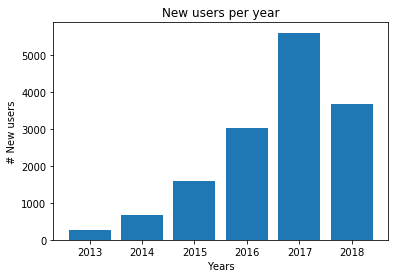

In [24]:
plt.bar(sorted(profile['year_joined'].unique().tolist()), profile.groupby(['year_joined'])['id'].count().tolist())
plt.xlabel("Years")
plt.ylabel("# New users")
plt.title("New users per year")

**The number of new users increased throughout the years and reached a peak of 5599 in 2017, then decreased in 2018 to 3669.**

## Exploring Transcript data

In [25]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


**Checking for missing values**

In [26]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

**It has no missing data**

**Extracting offer_id and other attributes from values column**

In [27]:
def extract_values(col):

    attrubutes = []        
    for idx, row in transcript.iterrows():
        for val in row['value']:
            if val in attrubutes:
                continue
            else:
                attrubutes.append(val)
    
    # we have 4 attributes: 'offer id', 'amount', 'offer_id', 'reward'
    # but 'offer id' and 'offer_id' are the same, we will use the latter one
    # let's encode them..
    
    # initializing columns
    transcript['offer_id'] = ''
    transcript['amount'] = 0
    transcript['reward'] = 0
    
    # iterating over transcript table
    for idx, row in transcript.iterrows():
        for val in row['value']:
            # check value column and update it, put each key in seperated column.
            if val == 'offer_id' or val == 'offer id':
                transcript.at[idx, 'offer_id']= row['value'][val]
            else:
                 transcript.at[idx, str(val)]= row['value'][val]
    
    # drop value column
    transcript.drop('value', axis=1, inplace=True)
                
    return transcript

In [28]:
transcript = extract_values(transcript)

In [29]:
transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [30]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
person      306534 non-null object
event       306534 non-null object
time        306534 non-null int64
offer_id    306534 non-null object
amount      306534 non-null int64
reward      306534 non-null int64
dtypes: int64(3), object(3)
memory usage: 14.0+ MB


**encoding offer_id as a number like we did previously**

In [31]:
transcript['offer_id'] = transcript['offer_id'].apply(lambda x: offers[x]+1 if x else None) 

In [32]:
transcript.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,4.0,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5.0,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,10.0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,7.0,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,2.0,0,0


In [33]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

**There are a total of 138953 transactions, 76277 users who recieved offers, 57725 users who actually viewed the offer, and only 33579 who completed the offer but it's not nessecarily that all of them have acted upon the offer's influence.**

**Getting the users who received offers**

In [34]:
users_who_received_offers = transcript[(transcript['event'] == 'offer received')]
users_who_received_offers.head()

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,4.0,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,5.0,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,10.0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,7.0,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,2.0,0,0


In [35]:
print("There are {} users who received offers".format(users_who_received_offers.shape[0]))

There are 76277 users who received offers


In [36]:
users_who_received_offers.groupby(['time', 'offer_id']).count()

person  event  amount  reward
time offer_id                               
0    1.0         1292   1292    1292    1292
     2.0         1218   1218    1218    1218
     3.0         1273   1273    1273    1273
     4.0         1245   1245    1245    1245
     5.0         1297   1297    1297    1297
     6.0         1221   1221    1221    1221
     7.0         1318   1318    1318    1318
     8.0         1266   1266    1266    1266
     9.0         1263   1263    1263    1263
     10.0        1257   1257    1257    1257
168  1.0         1319   1319    1319    1319
     2.0         1240   1240    1240    1240
     3.0         1266   1266    1266    1266
     4.0         1296   1296    1296    1296
     5.0         1245   1245    1245    1245
     6.0         1250   1250    1250    1250
     7.0         1250   1250    1250    1250
     8.0         1270   1270    1270    1270
     9.0         1263   1263    1263    1263
     10.0        1270   1270    1270    1270
336  1.0         1245   1245    1245    1245
     2.0         1280   1280    1280    1280
     3.0         1279   1279    1279    1279
     4.0         1275   1275    1275    1275
     5.0         1322   1322    1322    1322
     6.0         1301   1301    1301    1301
     7.0         1243   1243    1243    1243
     8.0         1256   1256    1256    1256
     9.0         1247   1247    1247    1247
     10.0        1263   1263    1263    1263
408  1.0         1278   1278    1278    1278
     2.0         1308   1308    1308    1308
     3.0         1275   1275    1275    1275
     4.0         1274   1274    1274    1274
     5.0         1269   1269    1269    1269
     6.0         1274   1274    1274    1274
     7.0         1222   1222    1222    1222
     8.0         1293   1293    1293    1293
     9.0         1250   1250    1250    1250
     10.0        1335   1335    1335    1335
504  1.0         1248   1248    1248    1248
     2.0         1310   1310    1310    1310
     3.0         1229   1229    1229    1229
     4.0         1261   1261    1261    1261
     5.0         1258   1258    1258    1258
     6.0         1286   1286    1286    1286
     7.0         1283   1283    1283    1283
     8.0         1238   1238    1238    1238
     9.0         1305   1305    1305    1305
     10.0        1286   1286    1286    1286
576  1.0         1276   1276    1276    1276
     2.0         1237   1237    1237    1237
     3.0         1295   1295    1295    1295
     4.0         1326   1326    1326    1326
     5.0         1277   1277    1277    1277
     6.0         1314   1314    1314    1314
     7.0         1281   1281    1281    1281
     8.0         1295   1295    1295    1295
     9.0         1243   1243    1243    1243
     10.0        1221   1221    1221    1221

**Average number of users who get offers in a week**

In [37]:
users_who_received_offers.groupby(['time']).count().mean()

person      12712.833333
event       12712.833333
offer_id    12712.833333
amount      12712.833333
reward      12712.833333
dtype: float64

**Average number of users who recieve a particular offer (offer 1 or offer 2 etc.)**

In [38]:
users_who_received_offers.groupby(['offer_id']).count().mean()

person    7627.7
event     7627.7
time      7627.7
amount    7627.7
reward    7627.7
dtype: float64

**Observations**
- This data is collected for the 76277 users who received offers over the period of 24 days, (576H/24H = 24 days)
- Each week 12713 users are sent offers.
- The number of users that will be sent a particular offer [offers 1:10] vary daily, but over the course of the experiment -on average- they are in the same range, i.e. each offer is sent to an approximately equal number of users (7628 user).

In [39]:
users_who_received_offers.describe()

,time,offer_id,amount,reward
count,76277.000000,76277.000000,76277.0,76277.0
mean,332.579519,5.495772,0.0,0.0
std,196.489548,2.871179,0.0,0.0
min,0.000000,1.000000,0.0,0.0
25%,168.000000,3.000000,0.0,0.0
50%,408.000000,5.000000,0.0,0.0
75%,504.000000,8.000000,0.0,0.0
max,576.000000,10.000000,0.0,0.0


**Observations**

- The average time that passes before a user received an offer is 332.5H (13.8 days)
- After 17 days (408H) half of the users have recieved an offer.
- By the third week, (504H) 75% of the users have recieved offers.

**Getting the users who viewed offer**

In [40]:
users_who_viewed_offers = transcript[transcript['event'] == 'offer viewed']
users_who_viewed_offers.head()

,person,event,time,offer_id,amount,reward
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,0,9.0,0,0
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,0,8.0,0,0
12652,102e9454054946fda62242d2e176fdce,offer viewed,0,2.0,0,0
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,0,1.0,0,0
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,0,8.0,0,0


In [41]:
print("There are {} users who viewed offers".format(users_who_viewed_offers.shape[0]))

There are 57725 users who viewed offers


**Getting the users who completed offers**

In [42]:
users_who_completed_offers = transcript[transcript['event'] == 'offer completed']
users_who_completed_offers.head()

,person,event,time,offer_id,amount,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,10.0,0,2
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,7.0,0,2
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,4.0,0,5
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,1.0,0,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,2.0,0,10


In [43]:
print("There are {} users who completed offers".format(users_who_completed_offers.shape[0]))

There are 33579 users who completed offers


**Getting the users who completed offers & was sent offers**

In [44]:
users_sent_and_completed_offers = users_who_completed_offers[users_who_completed_offers["person"].isin(users_who_received_offers["person"].tolist())]
users_sent_and_completed_offers.head()

,person,event,time,offer_id,amount,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,10.0,0,2
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,0,7.0,0,2
12679,629fc02d56414d91bca360decdfa9288,offer completed,0,4.0,0,5
12692,676506bad68e4161b9bbaffeb039626b,offer completed,0,1.0,0,10
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,0,2.0,0,10


In [45]:
print("There are {} users who were sent offers and completed offers".format(users_sent_and_completed_offers.shape[0]))

There are 33579 users who were sent offers and completed offers


**Observations:**
- Surprisingly, all users who received offers completed them

**Let's do a small sanity check:**

Show users who completed an offer and weren't sent one

In [46]:
users_who_completed_offers[~users_who_completed_offers["person"].isin(users_who_received_offers["person"].tolist())]

,person,event,time,offer_id,amount,reward


**There are none, that supports our statement. (all users who received offers completed them)**

But, let's be more sure and view a particular user's transactions in both dataframes:

In [47]:
users_who_received_offers[users_who_received_offers["person"] == '9fa9ae8f57894cc9a3b8a9bbe0fc1b2f']

,person,event,time,offer_id,amount,reward
36,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,0,10.0,0,0
110866,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,336,6.0,0,0
150635,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,408,5.0,0,0
201606,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer received,504,2.0,0,0


In [48]:
users_who_completed_offers[users_who_completed_offers["person"] == '9fa9ae8f57894cc9a3b8a9bbe0fc1b2f']

,person,event,time,offer_id,amount,reward
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,0,10.0,0,2
132815,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,354,6.0,0,3
193195,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,474,5.0,0,5
232881,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,540,2.0,0,10


In [49]:
profile[profile['id'].isin(users_sent_and_completed_offers['person'].tolist())].groupby('gender').count()

,age,id,income,year_joined
gender,,,,
F,5391,5391,5391,5391
M,6416,6416,6416,6416
O,179,179,179,179


In [50]:
profile[profile['id'].isin(users_sent_and_completed_offers['person'].tolist())].groupby('gender').mean()

,age,income,year_joined
gender,,,
F,57.904099,72703.394546,2016.555185
M,53.004520,63844.763092,2016.418797
O,54.905028,64262.569832,2016.625698


**Observations**
- Most users who completed offers were females.
- This may be due to the reason that their average income is the highest among users (72703).

In [63]:
users_sent_and_completed_offers.groupby('offer_id').count().sort_values('person', ascending= False)

,person,event,time,amount,reward
offer_id,,,,,
7.0,5317,5317,5317,5317,5317
6.0,5156,5156,5156,5156,5156
4.0,4354,4354,4354,4354,4354
9.0,4296,4296,4296,4296,4296
10.0,4017,4017,4017,4017,4017
1.0,3688,3688,3688,3688,3688
5.0,3420,3420,3420,3420,3420
2.0,3331,3331,3331,3331,3331


**Observations**
- Most users responded to offer 7 and 6, so Starbucks should provide these offers more frequently.

**Getting the users who purchased stuff (made transactions)**

In [51]:
users_who_made_transactions = transcript[transcript['event'] == 'transaction']
users_who_made_transactions.head()

,person,event,time,offer_id,amount,reward
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,NaN,0,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,NaN,34,0
12659,54890f68699049c2a04d415abc25e717,transaction,0,NaN,13,0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,NaN,19,0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,NaN,18,0


In [52]:
print("There are {} users who made transactions".format(users_who_made_transactions.shape[0]))

There are 138953 users who made transactions


In [53]:
X1 = profile[profile['id'].isin(users_sent_and_completed_offers['person'].tolist())].drop('id', axis=1)
X1['sent_offer'] = 1
X1.head()

,gender,age,income,year_joined,sent_offer
1,F,55,112000.0,2017,1
3,F,75,100000.0,2017,1
5,M,68,70000.0,2018,1
8,M,65,53000.0,2018,1
12,M,58,51000.0,2017,1


In [54]:
X2 = profile[~profile['id'].isin(users_sent_and_completed_offers['person'].tolist())].drop('id', axis=1)
X2['sent_offer'] = 0
X2.head()

,gender,age,income,year_joined,sent_offer
19,F,61,40000.0,2018,0
28,F,46,59000.0,2017,0
41,F,20,30000.0,2016,0
59,M,45,48000.0,2017,0
68,M,77,51000.0,2016,0


In [55]:
Data = pd.concat([X1.sample(n=3000), X2]).sample(frac=1)
Data['gender'].value_counts()

M    3650
F    2109
O      80
Name: gender, dtype: int64

In [56]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5839 entries, 12435 to 15171
Data columns (total 5 columns):
gender         5839 non-null object
age            5839 non-null int64
income         5839 non-null float64
year_joined    5839 non-null int64
sent_offer     5839 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 273.7+ KB


In [57]:
X = Data.drop(['sent_offer'], axis=1).values
y = Data['sent_offer'].values

In [58]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler

In [59]:
labelencoder_X = LabelEncoder()
X[:,0] = labelencoder_X.fit_transform(X[:,0])
X[:,-1] = labelencoder_X.fit_transform(X[:,-1])

In [ ]:
scaler = MinMaxScaler()
X[:,2] = scaler.fit_transform(X[:,2])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
X_train[:5]

In [ ]:
cls = RandomForestClassifier()

In [ ]:
cls.fit(X_train, y_train)

In [ ]:
preds = cls.predict(X_test)
preds

In [ ]:
y_test

In [ ]:
cls.score(X_test, y_test)